In [4]:
pip install openpyxl

   ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.0 kB ? eta -:--:--
   --- ----------------------------------- 20.5/250.0 kB 217.9 kB/s eta 0:00:02
   ------ -------------------------------- 41.0/250.0 kB 245.8 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/250.0 kB 416.7 kB/s eta 0:00:01
   --------------------- ---------------- 143.4/250.0 kB 607.9 kB/s eta 0:00:01
   ----------------------------- -------- 194.6/250.0 kB 784.3 kB/s eta 0:00:01
   -------------------------------------- 250.0/250.0 kB 807.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn import preprocessing as ps
import joblib
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def datetime2str(valuee):
  if isinstance(valuee, datetime.datetime):
    return str(valuee)
  else:
    return valuee

def arreglarStrings(string):
  if isinstance(string, str):
    return string.strip().upper()
  else:
    return string

In [18]:
df=pd.read_excel('../BD_URGENCIAS_BIO.xlsx')
df.head()

,COD,DESCRIPCION,Año,Mes,Paciente Tipo Identificacion,Nro Atencion,Servicio Admite,Servicio Anterior,Servicio Egreso,Tipo Egreso (INTERNACION),...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
0,1102,URGENCIAS ADULTO,2023,ENERO,CC,8597130640,URGENCIAS GENERALES SÓTANO,PISO 7 UCI NEUROCIRUGÍA,PISO 8 MEDICINA INTERNA NORTE,FALLECE,...,34.0,0.0,84.0,0.0,0.0,84,True,POBLACIÓN GENERAL,OTRAS ETNIAS,HIPERTENSION
1,1102,URGENCIAS ADULTO,2023,ENERO,CC,354450470,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,34.0,34,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
2,1102,URGENCIAS ADULTO,2023,ENERO,CC,4144136964,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,0.0,0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
3,1102,URGENCIAS ADULTO,2023,ENERO,CC,6090446598,HOSPITALIZACIÓN,CAMILLAS SALA 4 URGENCIAS,PISO 5 MEDICINA INTERNA NORTE,ALTA MÉDICA,...,0.0,6053.0,0.0,1092.0,0.0,1092,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
4,1102,URGENCIAS ADULTO,2023,ENERO,CC,3879330593,URGENCIAS GENERALES SÓTANO,CAMILLAS SALA 2 URGENCIAS,PISO 6 UCE,ALTA MÉDICA,...,69.0,0.0,286.0,0.0,0.0,286,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO


In [19]:
df = df.map(datetime2str)
df = df.map(arreglarStrings)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)
df['Grupo Poblacional'] = df['Grupo Poblacional'].astype(str)
df['Tiempo Duracion Diligenciamiento F3'] = df['Tiempo Duracion Diligenciamiento F3'].astype(str)
df.shape

(39745, 70)

In [15]:
unicos = df.nunique()
colUnicos = unicos[unicos == 1].index.tolist()
colUnicos

['COD', 'Año', 'Dias (Camara - F3)', 'Dias (Camara - Triaje)']

In [53]:
df_2 = df.drop(colUnicos, axis = 1)
df_2 = df_2.drop(['Servicio Admite', "Servicio Egreso", "Servicio Anterior"], axis = 1)
df_2.shape

(39745, 63)

In [137]:
cdata=df_2.select_dtypes(exclude=["int","float"]).columns
dataEncode=df_2.copy()
encoder=ps.LabelEncoder()
for i in cdata:
    dataEncode[i]=encoder.fit_transform(dataEncode[i])
dataEncode.head()


,DESCRIPCION,Mes,Paciente Tipo Identificacion,Nro Atencion,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
0,0,3,1,8597130640,2,48,1,3,20940,20950,...,34.0,0.0,84.0,0.0,0.0,84,1,3,2,6
1,0,3,1,354450470,4,5,2,3,19665,19673,...,0.0,0.0,0.0,0.0,34.0,34,0,3,2,10
2,0,3,1,4144136964,4,65,1,1,20252,20265,...,0.0,0.0,0.0,0.0,0.0,0,0,3,2,10
3,0,3,1,6090446598,0,48,1,0,20553,20567,...,0.0,6053.0,0.0,1092.0,0.0,1092,1,3,2,10
4,0,3,1,3879330593,0,19,1,0,20211,20224,...,69.0,0.0,286.0,0.0,0.0,286,0,3,2,10


In [138]:
def corrMatrix(dataEncode):
    corr_matrix = dataEncode.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    target_corr_df
    dataEncodePartida=dataEncode[target_corr_df.index[:12]]
    dataEncodePartida
    corr_matrix = dataEncodePartida.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    plt.figure(figsize=(10,10))
    sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
    plt.show()

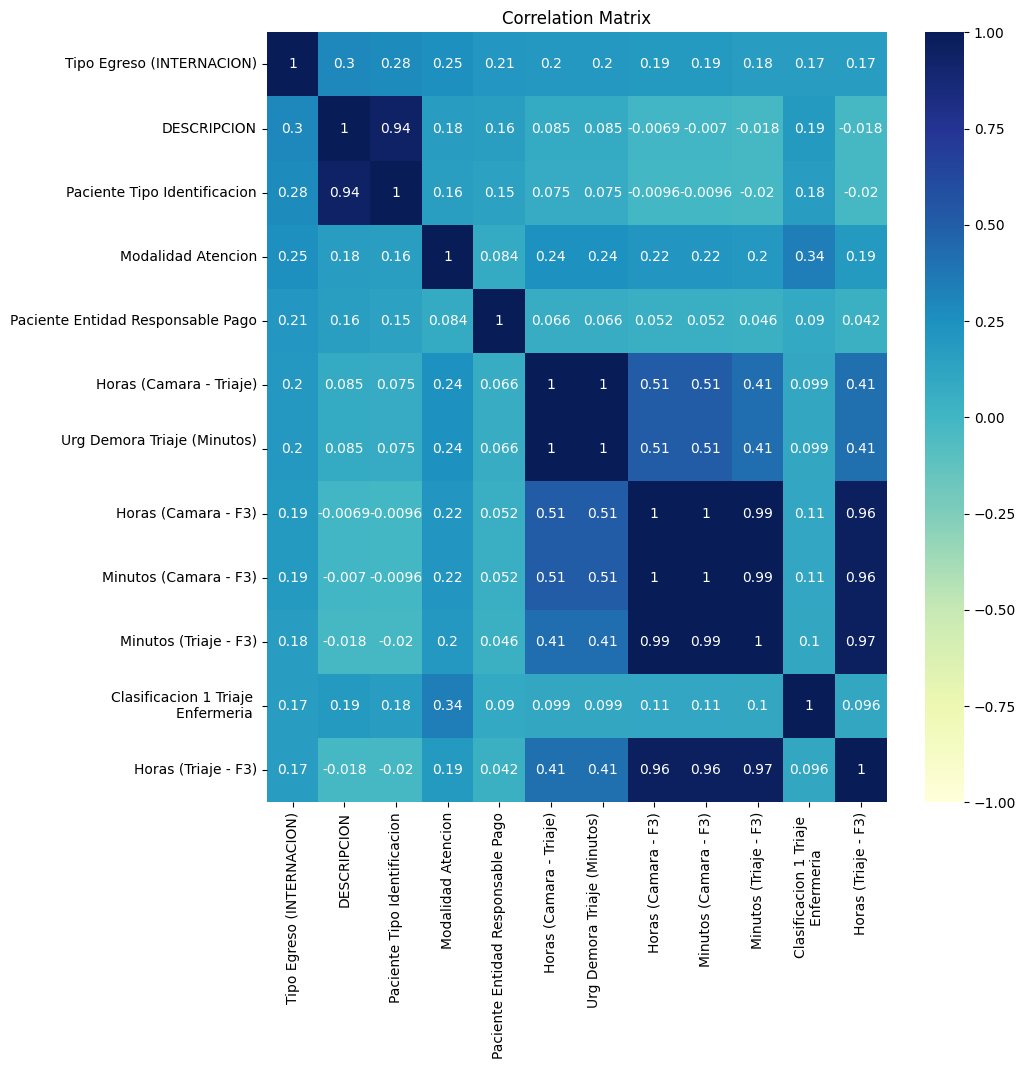

In [126]:
corrMatrix(dataEncode)

Por inspección que tenemos gracias a la matriz de correlacion podemos dropear las columnas de Horas y minutos de camara - F3 ya que tiene una correlación muy alta entre ellas con Minutos (Triaje - F3) y Horas (Triaje F3) que nos da la información de que aportan realmente lo mismo (También todos tienen el mismo peso con el Tipo Egreso), y lo mismo entre DESCRIPCION y Paciente Tipo Identificación, pues obtener casi la misma información de ambos.
Lo mismo se puede ver con  también con Urg Demora Triaje (Minutos) y Horas (Camara Triaje)

In [139]:
dropColumns = ["Horas (Camara - F3)", "Minutos (Camara - F3)", "Paciente Tipo Identificacion", "Horas (Triaje - F3)",
               "Urg Demora Triaje (Minutos)\n"]
dataEncode.drop(dropColumns, inplace=True, axis=1)
dataEncode.shape  

(39745, 58)

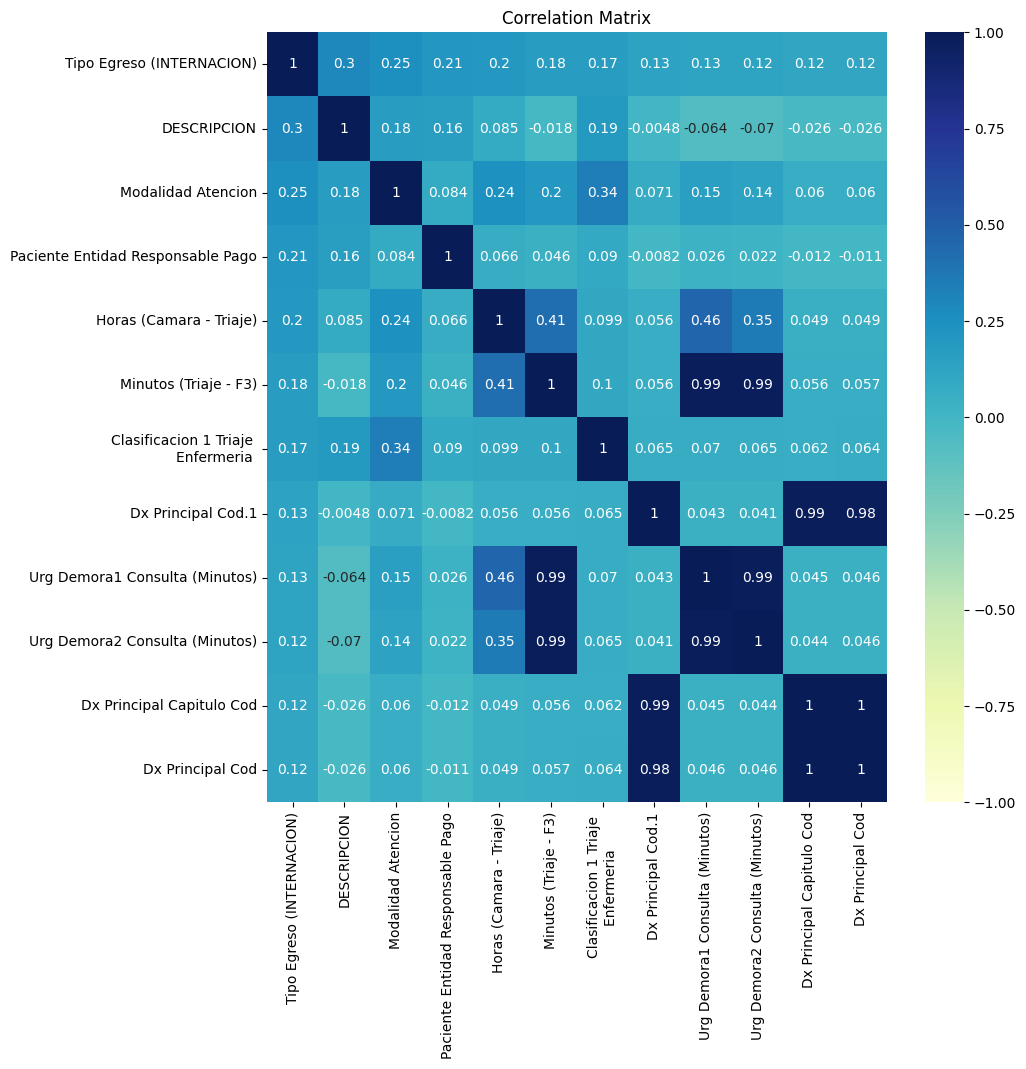

In [128]:
corrMatrix(dataEncode)

Repetimos el proceso con URG Demora Triaje (Minutos) y Horas (Triaje - F3).
Agregamos Urg Demora2 y Urg Demora1 porque también tienen alta correlación con Urg Demora Triaje.
También eliminamos aquellos de diagnóstico que no sean código.

In [140]:
dropColumns = ['Urg Demora2 Consulta (Minutos)', 'Urg Demora1 Consulta (Minutos)']
dataEncode.drop(dropColumns, inplace=True, axis=1)
dataEncode.shape  

(39745, 56)

In [146]:
listaDx = [i for i in dataEncode.columns.tolist() if i.startswith('Dx')]
listaEliminar = [i for i in listaDx if not("Cod" in i or "Tipo" in i) or (i.endswith(".1"))]
listaEliminar.append('Dx Principal Capitulo Cod')
dataEncode.drop(listaEliminar, inplace=True, axis=1)
dataEncode.shape  

(39745, 48)

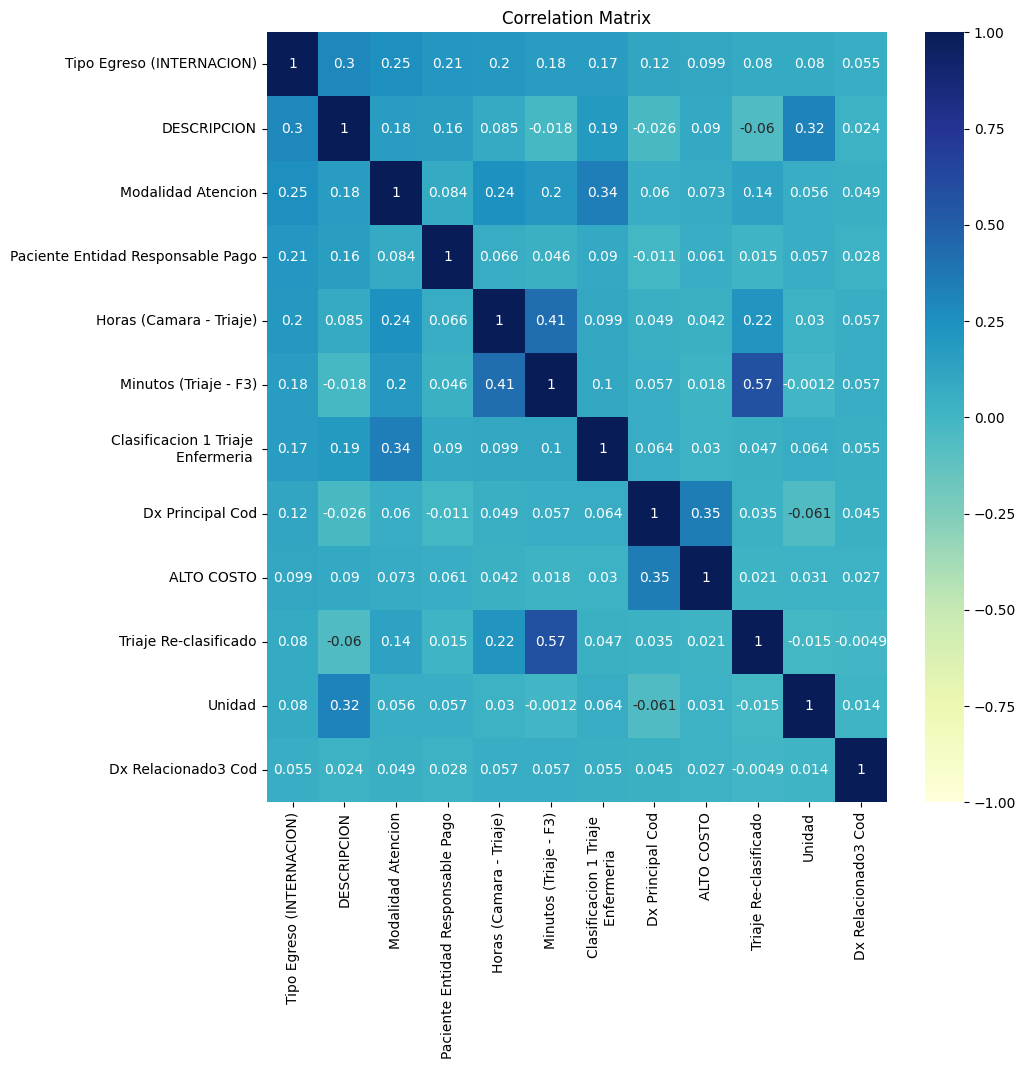

In [147]:
corrMatrix(dataEncode)

In [151]:
listaEEliminados = [i for i in df.columns.tolist() if not (i in dataEncode.columns.tolist())]
print(len(listaEEliminados))
for i in listaEEliminados:
    print(i)


22
COD
Año
Paciente Tipo Identificacion
Servicio Admite
Servicio Anterior
Servicio Egreso
Dias (Camara - F3)
Horas (Camara - F3)
Minutos (Camara - F3)
Urg Demora1 Consulta (Minutos)
Dias (Camara - Triaje)
Urg Demora Triaje (Minutos)

Horas (Triaje - F3)
Urg Demora2 Consulta (Minutos)
Dx Principal
Dx Principal Capitulo Cod
Dx Principal Capitulo

Dx Principal Cod.1
Dx Principal.1
Dx Relacionado1

Dx Relacionado2

Dx Relacionado3



TENER EN CUENTA QUE LAS VARIABLES ELIMINADAS POR SER COMBINACIÓN LINEAL SE TOMARON UNICAMENTE EN LA MATRIZ DE 12X12 DE CORRELACIONES, CUALQUIER VARIABLE QUE PUEDA SER COMBINACIÓN LINEAL DE OTRA PUEDE NO APARECER AHI.